# One-Year Mortality Prediction Project

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
admissions_df = pd.read_csv('./data/ADMISSIONS.csv')
#admissions_df.head(n=50)

In [4]:
patients_df = pd.read_csv('./data/PATIENTS.csv')
#patients_df.head(n=50)

### One Year Mortality 

In [6]:
life = pd.merge(admissions_df, patients_df,left_on = ['SUBJECT_ID'],right_on= ['SUBJECT_ID'], how = 'left')
life = life.loc[:,['SUBJECT_ID','HADM_ID','ADMITTIME','DOD']]

In [7]:
life['ADMITTIME'] = pd.to_datetime(life['ADMITTIME'])
life['DOD'] = pd.to_datetime(life['DOD'])
life['alive_days'] = (life['DOD']-life['ADMITTIME']).dt.days
life['alive_days'] = life['alive_days'].fillna(1000).astype(int)
for i,r in life.iterrows():
    if life.loc[i,'alive_days'] == 1000:
        life.loc[i, '1-year_mortality'] = 0
    elif life.loc[i,'alive_days'] > 365:
        life.loc[i, '1-year_mortality'] = 0
    else:
        life.loc[i, '1-year_mortality'] = 1
#life #['alive_days']

### Ages 

In [8]:
age = pd.merge(admissions_df, patients_df,left_on = ['SUBJECT_ID'],right_on= ['SUBJECT_ID'], how = 'left')
age = age.loc[:,['SUBJECT_ID','HADM_ID','ADMITTIME','DOB']]

In [9]:
age['ADMITTIME'] = pd.to_datetime(age['ADMITTIME'])
age['DOB'] = pd.to_datetime(age['DOB'])
age['Ages'] = age['ADMITTIME'].dt.year - age['DOB'].dt.year 

In [10]:
upperlimit = np.percentile(age['Ages'], [75]) + 1.5 * (np.percentile(age['Ages'], [75])- np.percentile(age['Ages'], [25]))
lowerlimit = np.percentile(age['Ages'], [25]) - 1.5 * (np.percentile(age['Ages'], [75])- np.percentile(age['Ages'], [25]))
print(upperlimit)
print(lowerlimit)

[125.5]
[-6.5]


In [11]:
age = age.drop(age[(age['Ages'] < 0) | (age['Ages'] > upperlimit[0])].index)
ages = age.drop(['SUBJECT_ID','ADMITTIME','DOB'],axis = 1)

In [12]:
Age = pd.merge(life, ages, left_on = ['HADM_ID'],right_on= ['HADM_ID'], how ='inner')
Age = Age.drop(['ADMITTIME','DOD','alive_days'], axis = 1)

### Age at First Admission

In [14]:
age_first_admit = age.groupby("SUBJECT_ID",as_index=False)["Ages"].min()
age_first_admit.columns = ['SUBJECT_ID','Ages_fir_admit']

In [15]:
Age_fir = pd.merge(Age, age_first_admit, left_on = ['SUBJECT_ID'],right_on= ['SUBJECT_ID'], how ='left')

In [16]:
Age_fir['Ages'].corr(Age_fir['Ages_fir_admit'])

0.9987738832458651

The matrix feature will not include 'Ages at subject's first admission', as it is highly corrolated with 'Ages at admission'.

### Diseases

In [17]:
diagnoses = pd.read_csv('./data/DIAGNOSES_ICD.csv')

In [18]:
dxref_2015_df = pd.read_csv('./data/$dxref 2015.csv',skipinitialspace = True, skiprows=1)

In [19]:
dxref_2015_df.columns = dxref_2015_df.columns.str.strip(' ').str.strip('\'')
dxref_2015 = dxref_2015_df.apply(lambda x:x.str.strip('\'')).apply(lambda x:x.str.strip(' '))

In [20]:
diag = pd.merge(diagnoses,dxref_2015,left_on = ['ICD9_CODE'],right_on= ['ICD-9-CM CODE'], how = 'left')

In [21]:
diseases = diag.groupby(['HADM_ID', 'Category']).size().unstack()

In [22]:
diseases = diseases.fillna(0)
diseases = diseases.where(diseases == 0.0, other = 1)

In [23]:
diseases['Certain Conditions Originating In The Perinatal Period'].isnull().any()

False

In [24]:
Diseases = pd.merge(Age, diseases, left_on = ['HADM_ID'],right_on= diseases.index, how ='inner')

### Comorbidity

In [25]:
diagnoses['Num_Diag'] = ''
counts = diagnoses.groupby('HADM_ID').count()['Num_Diag']

Num_Diag = pd.DataFrame({'Num_Diag':counts.values}, index = counts.index)

In [26]:
Comorb = pd.merge(Num_Diag, Diseases, left_on= Num_Diag.index, right_on = ['HADM_ID'], how = 'inner')
#Comorb = Comorb.loc[:,['SUBJECT_ID','HADM_ID','Num_Can','Num_Diag','1-year_mortality']]

### Gender 

In [27]:
gender = patients_df.loc[:,['SUBJECT_ID','GENDER']]

In [28]:
dummies_gen = pd.get_dummies(gender['GENDER'])

In [29]:
gender = pd.concat([gender, dummies_gen], axis=1).drop(['GENDER'], axis = 1)

In [30]:
Gender = pd.merge(gender, Comorb, left_on = ['SUBJECT_ID'], right_on= ['SUBJECT_ID'], how = 'right')
#Gender = Gender.loc[:,['SUBJECT_ID','HADM_ID','Num_Can','Num_Diag','F','M','1-year_mortality']]

## Data Exploration 

First, it is essential to look at the percentage of one-mortality in this database.

In [31]:
Gender['1-year_mortality'].value_counts()

0.0    43549
1.0    12766
Name: 1-year_mortality, dtype: int64

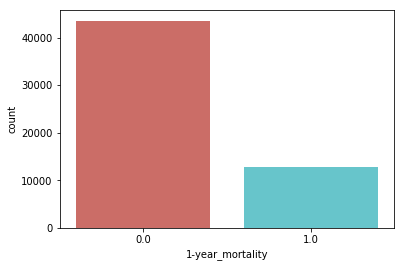

In [32]:
sns.countplot(x ='1-year_mortality', data = Gender, palette = 'hls')
plt.show()

In [33]:
percen_mortality0 = 43549/(43549+12766)
percen_mortality1 = 1-percen_mortality0
print(percen_mortality0)
print(percen_mortality1)

0.7733108408061795
0.2266891591938205


We could look at the relative proportions of death/alive for different diseases and genders.

In [34]:
feature = Gender.groupby('1-year_mortality').mean().drop(['SUBJECT_ID','HADM_ID'], axis = 1)
feature = feature.drop(['Num_Diag','Ages'],axis = 1)
feature

,F,M,Certain Conditions Originating In The Perinatal Period,"Complications Of Pregnancy, Childbirth, And The Puerperium",Congenital Anomalies,Diseases Of The Circulatory System,Diseases Of The Digestive System,Diseases Of The Genitourinary System,Diseases Of The Musculoskeletal System And Connective Tissue,Diseases Of The Nervous System And Sense Organs,...,Diseases Of The Skin And Subcutaneous Tissue,Diseases of The Blood And Blood-Forming Organs,"Endocrine, Nutritional and Metabolic Diseases, And Immunity Disorders",Infectious and Parasitic Diseases,Injury And Poisoning,Mental Disorders,Neoplasms,Supplementary Classification Of External Causes Of Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,"Symptoms, Signs, And Ill-Defined Conditions"
1-year_mortality,,,,,,,,,,,,,,,,,,,,,
0.0,0.430733,0.569267,0.124526,0.003651,0.065375,0.664194,0.322212,0.296907,0.160486,0.243863,...,0.085031,0.285885,0.556431,0.194723,0.358401,0.268870,0.101564,0.278146,0.576247,0.292498
1.0,0.439214,0.560786,0.005092,0.000470,0.025302,0.878192,0.460833,0.567836,0.185336,0.342472,...,0.159799,0.455350,0.738603,0.412267,0.466943,0.287091,0.324456,0.289676,0.602538,0.497337


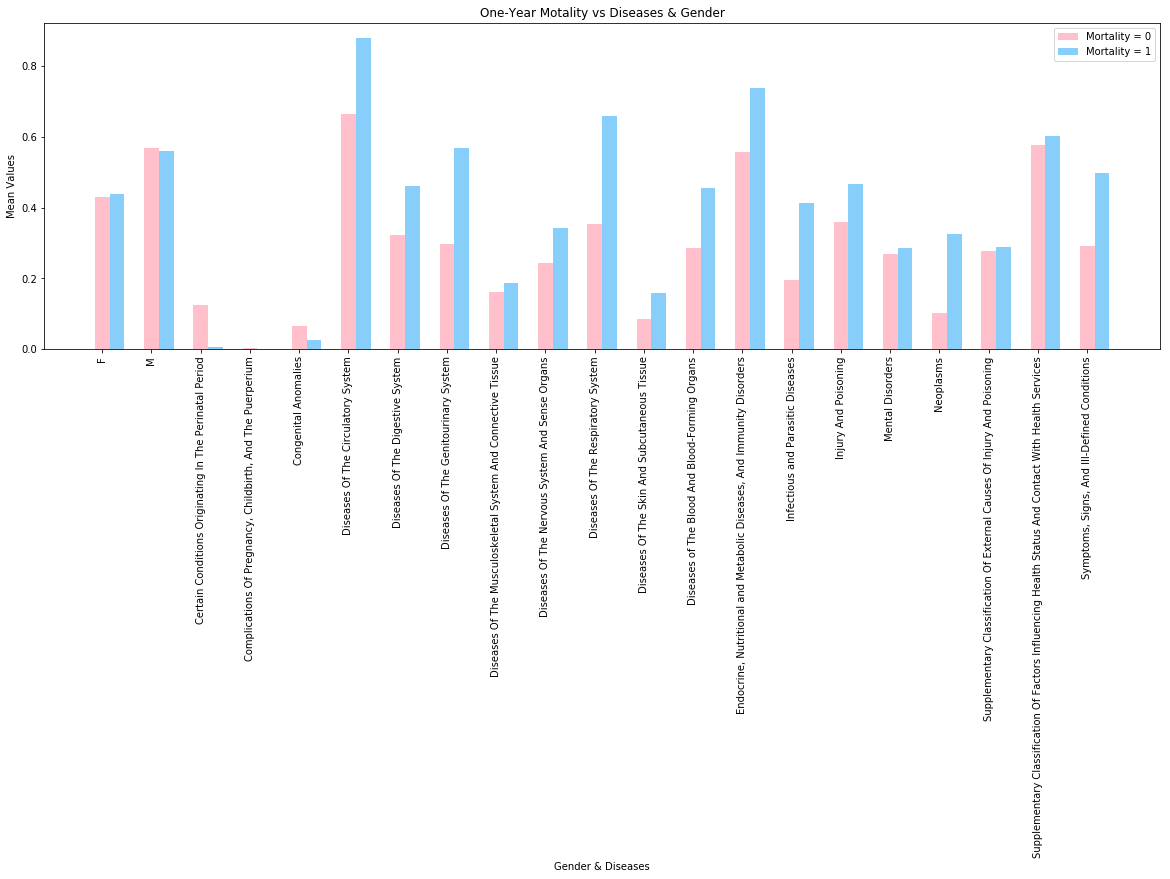

In [158]:
name = feature.columns.tolist()
mortality0 = feature[feature.index == 0.0].values[0]
mortality1 = feature[feature.index == 1.0].values[0]

x = np.arange(21)
plt.figure(figsize=(20,6))
y_pos = np.arange(len(name))
plt.xticks(y_pos, name)
plt.xticks(rotation=90)
plt.bar(x, mortality0, width = 0.3, color = 'pink', label = 'Mortality = 0' )
plt.bar(x + 0.3, mortality1, width = 0.3, color ='lightskyblue', label = 'Mortality = 1')
plt.title('One-Year Motality vs Diseases & Gender')
plt.xlabel('Gender & Diseases')
plt.ylabel('Mean Values')
plt.legend()
plt.show()

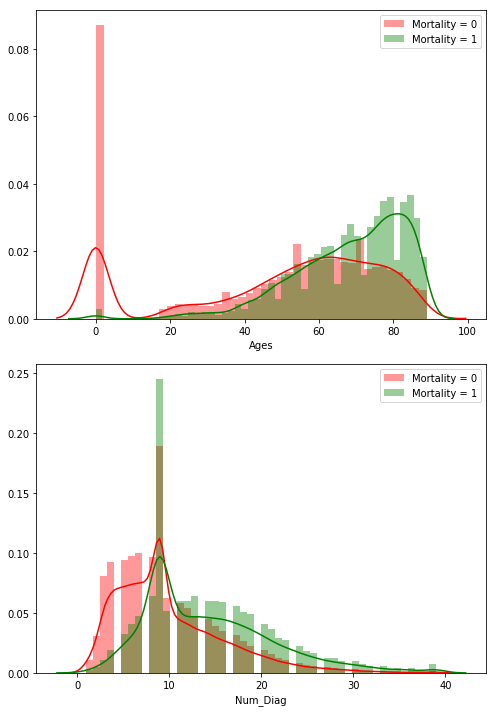

In [42]:
fig = plt.figure(figsize = (7, 10))
plt.title('One-Year Motality vs Ages & Num_Diag')

plt.subplot(2,1,1)
sns.distplot(Gender['Ages'][Gender['1-year_mortality']==0], color = 'red', label = 'Mortality = 0')
sns.distplot(Gender['Ages'][Gender['1-year_mortality']==1], color = 'green', label = 'Mortality = 1')
plt.legend(loc='best')

plt.subplot(2,1,2)
sns.distplot(Gender['Num_Diag'][Gender['1-year_mortality']==0], color = 'red', label = 'Mortality = 0')
sns.distplot(Gender['Num_Diag'][Gender['1-year_mortality']==1], color = 'green', label = 'Mortality = 1')
plt.legend(loc='best')

fig.tight_layout()
plt.show()

Finally, all the features are checked using corrolations.

In [35]:
data = Gender.drop(['SUBJECT_ID','HADM_ID','1-year_mortality'], axis=1)
intercept_weight = pd.DataFrame({'intercept':[1]*data.shape[0]})
data = pd.concat([intercept_weight, data], axis = 1)
data.astype(int)

,intercept,F,M,Num_Diag,Ages,Certain Conditions Originating In The Perinatal Period,"Complications Of Pregnancy, Childbirth, And The Puerperium",Congenital Anomalies,Diseases Of The Circulatory System,Diseases Of The Digestive System,...,Diseases Of The Skin And Subcutaneous Tissue,Diseases of The Blood And Blood-Forming Organs,"Endocrine, Nutritional and Metabolic Diseases, And Immunity Disorders",Infectious and Parasitic Diseases,Injury And Poisoning,Mental Disorders,Neoplasms,Supplementary Classification Of External Causes Of Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,"Symptoms, Signs, And Ill-Defined Conditions"
0,1,1,0,16,74,0,0,0,1,1,...,0,1,1,0,1,0,0,0,0,1
1,1,1,0,17,80,0,0,0,1,1,...,0,1,1,0,0,0,0,0,0,1
2,1,1,0,26,81,0,0,0,1,1,...,0,1,1,0,1,0,1,1,1,0
3,1,1,0,12,24,0,0,0,1,0,...,0,1,0,1,1,0,1,0,0,1
4,1,0,1,5,20,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
5,1,0,1,27,55,0,0,0,1,1,...,0,1,1,1,1,1,0,1,1,1
6,1,0,1,5,55,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,1
7,1,1,0,9,85,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
8,1,0,1,4,78,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
9,1,0,1,11,84,0,0,0,1,1,...,0,0,1,1,0,0,0,0,1,0


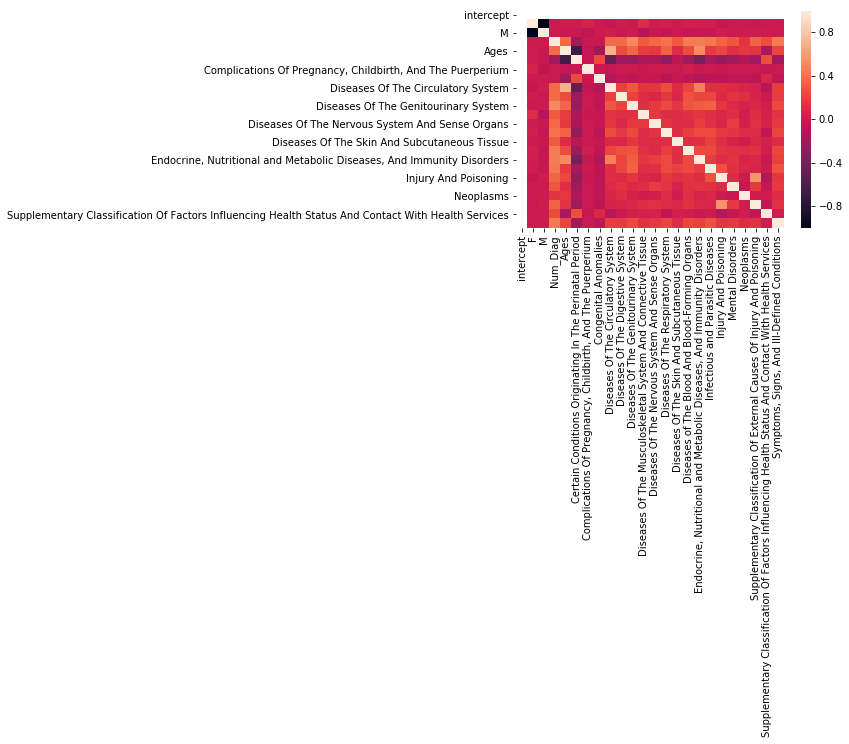

In [36]:
corr = data.corr()
sns.heatmap(corr)

In [37]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]
data

,intercept,F,M,Num_Diag,Ages,Certain Conditions Originating In The Perinatal Period,"Complications Of Pregnancy, Childbirth, And The Puerperium",Congenital Anomalies,Diseases Of The Circulatory System,Diseases Of The Digestive System,...,Diseases Of The Skin And Subcutaneous Tissue,Diseases of The Blood And Blood-Forming Organs,"Endocrine, Nutritional and Metabolic Diseases, And Immunity Disorders",Infectious and Parasitic Diseases,Injury And Poisoning,Mental Disorders,Neoplasms,Supplementary Classification Of External Causes Of Injury And Poisoning,Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services,"Symptoms, Signs, And Ill-Defined Conditions"
0,1,1,0,16,74,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,1,0,17,80,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,0,26,81,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
3,1,1,0,12,24,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,1,0,1,5,20,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
5,1,0,1,27,55,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
6,1,0,1,5,55,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,1,1,0,9,85,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,0,1,4,78,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1,0,1,11,84,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [38]:
result = pd.DataFrame()
result['1-year_mortality'] = Gender['1-year_mortality']
result

,1-year_mortality
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


## Modeling 

Since this is a classification model, the following models are used: 

    *SVC
    *Logistic Regression
    *Random Forest
    *Gradient Boosting Trees
    *Decision Trees

Model are evaluated by Accuracy, Receiver operating characteristic(ROC) curve and the Area Under Curve(AUC) of ROC.

In [39]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

### SVC 

In [115]:
x_train, x_test, y_train, y_test = train_test_split(data.values, result.values,\
                                                    test_size = 0.2)

In [43]:
svc = svm.SVC(probability=True).fit(x_train, y_train) # Fit with SVM 

In [126]:
accu_svc = svc.score(x_test,y_test)
accu_svc

0.7997869129006482

In [127]:
new_svc = svc.predict_proba(data.values)

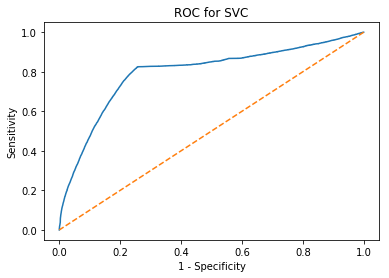

In [129]:
spec_svc, sens_svc, thresholds_svc = metrics.roc_curve(result.values, new_svc[:,1])
plt.plot(spec_svc, sens_svc)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('ROC for SVC')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [130]:
AUC_svc = metrics.roc_auc_score(result.values, pred_svc[:,1])
AUC_svc

0.7946416192604593

### Logistic Regression

In [131]:
logs = LogisticRegression().fit(x_train, y_train)

In [132]:
accu_logs = logs.score(x_test,y_test)
accu_logs

0.7944597354168517

In [133]:
new_logs = logs.predict_proba(data.values)

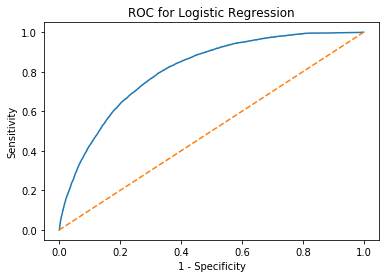

In [134]:
spec_logs, sens_logs, thresholds_logs = metrics.roc_curve(result.values, new_logs[:,1])
plt.plot(spec_logs, sens_logs)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('ROC for Logistic Regression')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [135]:
AUC_logs = metrics.roc_auc_score(result.values, new_logs[:,1])
AUC_logs

0.8069211786829846

### Random Forest

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
raf = RandomForestClassifier().fit(x_train, y_train)

In [140]:
accu_raf = raf.score(x_test,y_test)
accu_raf

0.937565479889905

In [141]:
new_raf = raf.predict_proba(data.values)

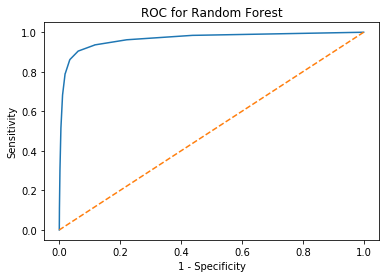

In [142]:
spec_raf, sens_raf, thresholds_raf = metrics.roc_curve(result.values, new_raf[:,1])
plt.plot(spec_raf, sens_raf)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('ROC for Random Forest')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [143]:
AUC_raf = metrics.roc_auc_score(result.values, new_raf[:,1])
AUC_raf

0.9661260510709472

### Gradient Boosting Classifier

In [144]:
from sklearn.ensemble import GradientBoostingClassifier

In [145]:
GBC = GradientBoostingClassifier().fit(x_train, y_train)

In [146]:
accu_GBC = GBC.score(x_test,y_test)
accu_GBC

0.7953475983308177

In [147]:
new_GBC = GBC.predict_proba(data.values)

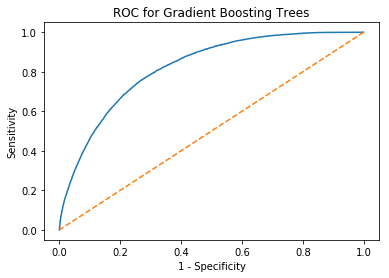

In [148]:
spec_GBC, sens_GBC, thresholds_GBC = metrics.roc_curve(result.values, new_GBC[:,1])
plt.plot(spec_GBC, sens_GBC)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('ROC for Gradient Boosting Trees')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [149]:
AUC_GBC = metrics.roc_auc_score(result.values, new_GBC[:,1])
AUC_GBC

0.8211595604623376

###  Decision Trees

In [150]:
from sklearn import tree

In [151]:
DT = tree.DecisionTreeClassifier().fit(x_train, y_train)

In [152]:
accu_DT = DT.score(x_test,y_test)
accu_DT

0.7254727870016869

In [153]:
new_DT = DT.predict_proba(data.values)

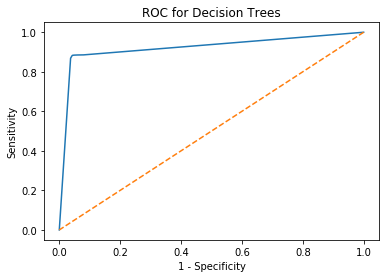

In [154]:
spec_DT, sens_DT, thresholds_DT = metrics.roc_curve(result.values, new_DT[:,1])
plt.plot(spec_DT, sens_DT)
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.title('ROC for Decision Trees')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [155]:
AUC_DT = metrics.roc_auc_score(result.values, new_DT[:,1])
AUC_DT

0.9213557593651622

### Result Summary

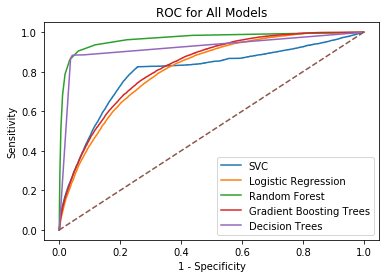

In [156]:
plt.figure()
plt.plot(spec_svc, sens_svc, label = 'SVC')
plt.plot(spec_logs, sens_logs, label = 'Logistic Regression')
plt.plot(spec_raf, sens_raf, label = 'Random Forest')
plt.plot(spec_GBC, sens_GBC, label = 'Gradient Boosting Trees')
plt.plot(spec_DT, sens_DT, label = 'Decision Trees')
plt.plot([1, 0],[1, 0], linestyle = "--")
plt.legend()
plt.title('ROC for All Models')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [157]:
summary = pd.DataFrame({'Accuracy':[accu_svc,accu_logs,accu_raf,accu_GBC,accu_DT], \
                        'AUC':[AUC_svc, AUC_logs, AUC_raf, AUC_GBC, AUC_DT]})
summary.index = ['SVC','Logistic Regression','Random Forest','Gradient Boosting Trees','Decision Trees']
summary

,Accuracy,AUC
SVC,0.799787,0.794642
Logistic Regression,0.794460,0.806921
Random Forest,0.937565,0.966126
Gradient Boosting Trees,0.795348,0.821160
Decision Trees,0.725473,0.921356


Based on the ROC and tables above, it could be concluded that Random Forest would be the best model to use in this project, as it has highest accuracy and AUC, as well as best ROC.